# aSPEM Experiment : analysis




TODO: tester qu'à chaque pause, l'agent se réinitialise à $\hat{p}=.5$

In [1]:
%run 0_parameters.ipynb


WELCOME



In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
msfigpath = '../PasturelMontagniniPerrinet2019/figures'

In [5]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

# find_h_with_MI

In [6]:
def regress(ax, p, data, t_label=10, color='k', lw=2, axis=None) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    
    ax.plot(x_test, fitLine, c=color, linewidth=lw)

    if axis is None :
        x1, x2 = np.min(p), np.max(p)
        y1, y2 = np.min(data), np.max(data)
    else :
        x1, x2, y1, y2  = axis[0], axis[1], axis[2], axis[3]
    #x_pos=x2-(x2-x1)/10 ; h_pos='right'
    #x_pos=x1+(x2-x1)/10 ; h_pos='left'
    #y_pos_r=y2-(y2-y1)/10 ; y_pos_m=y2-2*(y2-y1)/10
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10

    
    ax.text(x2, y_pos_r, 'r = %0.3f'%(r_), color=color, fontsize=t_label/1.2, ha='right')
    
    return ax


In [7]:
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Weighted_correlation_coefficient
# https://stackoverflow.com/questions/38641691/weighted-correlation-coefficient-with-pandas
def r_weight(ax, x, y, w, t_label=10, color='k', lw=2, axis=None) :
    
    x = np.ma.masked_array(x, mask=np.isnan(y)).compressed()
    y = np.ma.masked_array(y, mask=np.isnan(y)).compressed()
    
    def m(x, w):
        """Weighted Mean"""
        return np.sum(x * w) / np.sum(w)

    def cov(x, y, w):
        """Weighted Covariance"""
        return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

    def corr(x, y, w):
        """Weighted Correlation"""
        return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))    

    r = corr(x, y, w)
    
    
    if axis is None :
        x1, x2 = np.min(x), np.max(x)
        y1, y2 = np.min(y), np.max(y)
    else :
        x1, x2, y1, y2  = axis[0], axis[1], axis[2], axis[3]
    
    
    
    #x_pos=x2-(x2-x1)/10 ; h_pos='right'
    #x_pos=x1+(x2-x1)/10 ; h_pos='left'
    #y_pos_r=y2-(y2-y1)/10 ; y_pos_m=y2-2*(y2-y1)/10
    y_pos_r=y1+(y2-y1)/10 ; y_pos_m=y1+2*(y2-y1)/10

    ax.text(x1, y_pos_r, 'r weight = %0.3f'%(r), color=color, fontsize=t_label/1.2, ha='left')
    
    return ax


In [8]:
list_suj = {'AM': 'F', 'BMC': 'M', 'CS': 'F', 'DC': 'F',
            'FM': 'F', 'IP': 'F',  'LB': 'F', 'OP': 'M',
            'RS': 'M', 'SR': 'F',  'TN': 'M', 'YK': 'M'}

In [9]:
def plot_fig(recording, nb_r) :
    fig, ax = plt.subplots(3,2,figsize=(15,20))

    Full = e.Full_list(modes_bcp=[])
    list_h = recording['list_h'][:]

    COLOR = ['b', 'r', 'k', 'g', 'm', 'c',
             'gold', 'darkred', 'peru', 'silver', 'plum', 'olivedrab']

    h_va_full, h_bet_full = [[], []], [[], []]
    h_va_F, h_bet_F = [[], []], [[], []]
    h_va_M, h_bet_M = [[], []], [[], []]
    r_va_full, r_bet_full = [[], []], [[], []]
    
    if nb_r==100 : range_d = range(0, 3*200-50, 50)
    elif nb_r==150 : range_d = range(0, 3*200-100, 50)
    elif nb_r==200 : range_d = range(0, 3*200-150, 50)
    elif nb_r=='block' : range_d = range(0, 3*200-150, 200)
    
    for num, s in enumerate(list_suj.keys()) :
        if list_suj[s]=='F' : coco='r'
        else :                coco='b'
        
        print(s, end=' ')

        h_va_s, h_bet_s = [[], []], [[], []]
        r_va_s, r_bet_s = [[], []], [[], []]

        for d, c in enumerate(range_d) :
            

            r_va = recording['r_va'][s][d][:]
            r_bet = recording['r_bet'][s][d][:]

            h_va_s[0].append(list_h[np.argmax(r_va)]) ; h_bet_s[0].append(list_h[np.argmax(r_bet)])
            h_va_s[1].append(list_h[np.argmax(r_va)] if np.max(r_va) > 0.6 else np.nan)
            h_bet_s[1].append(list_h[np.argmax(r_bet)] if np.max(r_bet) > 0.6 else np.nan)

            for a in range(2) : r_va_s[a].append(np.max(r_va)) ; r_bet_s[a].append(np.max(r_bet))

            
        for a in range(2) :
            if nb_r in ['block', 200] : b0=1
            elif nb_r==150            : b0=2
            elif nb_r==100            : b0=3

            ax[0][a].scatter(h_va_s[a][:b0], h_bet_s[a][:b0], c=COLOR[num], alpha=0.5,
                          s=(np.array(r_va_s[a][:b0])*np.array(r_bet_s[a][:b0]))*400, lw=2, edgecolors=coco,
                          marker='*' if s in ['TN', 'LB'] else None)
            ax[0][a].scatter(h_va_s[a][b0:], h_bet_s[a][b0:], c=COLOR[num], alpha=0.5,
                          s=(np.array(r_va_s[a][b0:])*np.array(r_bet_s[a][b0:]))*400, lw=2, edgecolors=coco)

            #print('\nBet :\nh=', h_bet_100[:4], '\nr=', r_bet[:4], '\n\nva :\nh=', h_va_100[:4], '\nr=', r_va[:4], end='\n\n\n')
            '''ax.scatter(h_va_s, h_bet_s, c=COLOR[num], alpha=0.5, s=(np.array(r_va_s)*np.array(r_bet_s))*400,
                       marker='*' if s in ['TN', 'LB'] else None, linewidths=2, edgecolors=coco)'''


            h_va_full[a].extend(h_va_s[a]) ; h_bet_full[a].extend(h_bet_s[a])
            r_va_full[a].extend(r_va_s[a])     ; r_bet_full[a].extend(r_bet_s[a])
            
            
            if list_suj[s]=='F' :
                h_va_F[a].extend(h_va_s[a][b] if np.isnan(h_bet_s[a][b])==False else np.nan for b in range(len(h_va_s[a])))
                h_bet_F[a].extend(h_bet_s[a][b] if np.isnan(h_va_s[a][b])==False else np.nan for b in range(len(h_va_s[a])))
            else :
                h_va_M[a].extend(h_va_s[a][b] if np.isnan(h_bet_s[a][b])==False else np.nan for b in range(len(h_va_s[a])))
                h_bet_M[a].extend(h_bet_s[a][b] if np.isnan(h_va_s[a][b])==False else np.nan for b in range(len(h_va_s[a])) )


    for a in range(2) :
        h_va_full[a] = np.ma.masked_array(h_va_full[a], mask=np.isnan(h_bet_full[a])).compressed()
        r_va_full[a] = np.ma.masked_array(r_va_full[a], mask=np.isnan(h_bet_full[a])).compressed()
        r_bet_full[a] = np.ma.masked_array(r_bet_full[a], mask=np.isnan(h_bet_full[a])).compressed()
        h_bet_full[a] = np.ma.masked_array(h_bet_full[a], mask=np.isnan(h_bet_full[a])).compressed()

        h_bet_full[a] = np.ma.masked_array(h_bet_full[a], mask=np.isnan(h_va_full[a])).compressed()
        r_bet_full[a] = np.ma.masked_array(r_bet_full[a], mask=np.isnan(h_va_full[a])).compressed()
        r_va_full[a] = np.ma.masked_array(r_va_full[a], mask=np.isnan(h_va_full[a])).compressed()
        h_va_full[a] = np.ma.masked_array(h_va_full[a], mask=np.isnan(h_va_full[a])).compressed()

        r_va_full[a] = np.array(r_va_full[a])
        r_bet_full[a] = np.array(r_bet_full[a])


        axis_r = [min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100, min(list_h)-min(list_h)/100, max(list_h)+max(list_h)/100]
        ax[0][a] = regress(ax[0][a], np.log(h_bet_full[a]), np.log(h_va_full[a]), t_label=20, color='k', lw=2, axis=axis_r)
        ax[0][a] = r_weight(ax[0][a], np.log(h_bet_full[a]), np.log(h_va_full[a]), r_va_full[a]*r_bet_full[a], t_label=20, color='k', lw=2, axis=axis_r)

        ax[0][a].plot(np.arange(-10,10), np.arange(-10,10), '--k')
        ax[0][a].vlines(0.025, 0, 0.025, colors='k')
        ax[0][a].hlines(0.025, 0, 0.025, colors='k')

        ax[0][a].set_xlabel('$h_{va}$', fontsize=20) ; ax[0][a].set_xlim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
        ax[0][a].set_ylabel('$h_{bet}$', fontsize=20)  ; ax[0][a].set_ylim(min(list_h)-min(list_h)/10, max(list_h)+max(list_h)/10)
        ax[0][a].set_xscale("log") ; ax[0][a].set_yscale("log")
    
    
    
        range_his = (np.log(min(list_h)), np.log(max(list_h)))
        bins_his=20
        
        ax[1][a].hist(np.log(h_va_full[a]), bins=bins_his, alpha=0.5, color='k', range=range_his)
        ax[1][a].hist([np.log(h_va_F[a]), np.log(h_va_M[a])], bins=bins_his, alpha=0.5, color=['r', 'b'],
                      range=range_his)#, histtype = 'barstacked')
        
        #ax[1][a].hist(np.log(h_va_M[a]), bins=bins_his, alpha=0.5, color='b', range=range_his)
        ax[1][a].set_xlim(np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10))
        ax[1][a].set_title("hist h_va")
        
        
        ax[2][a].hist(np.log(h_bet_full[a]), bins=bins_his, alpha=0.5, color='k', range=range_his)
        ax[2][a].hist([np.log(h_bet_F[a]), np.log(h_bet_M[a])], bins=bins_his, alpha=0.5, color=['r', 'b'],
                      range=range_his)#, histtype = 'barstacked')
        #ax[2][a].hist(np.log(h_bet_F[a]), bins=bins_his, alpha=0.5, color='r', range=range_his)
        #ax[2][a].hist(np.log(h_bet_M[a]), bins=bins_his, alpha=0.5, color='b', range=range_his)
        ax[2][a].set_xlim(np.log(min(list_h)-min(list_h)/10), np.log(max(list_h)+max(list_h)/10))
        ax[2][a].set_title("hist h_bet")
        
        #ax[1][a].set_xscale("log")
    
    ax[0][0].set_title("Full R") ; ax[0][1].set_title("R > .6")
    
        
    
    plt.show()

In [11]:
import pickle

OP CS IP YK RS AM DC FM TN BMC SR LB 

/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


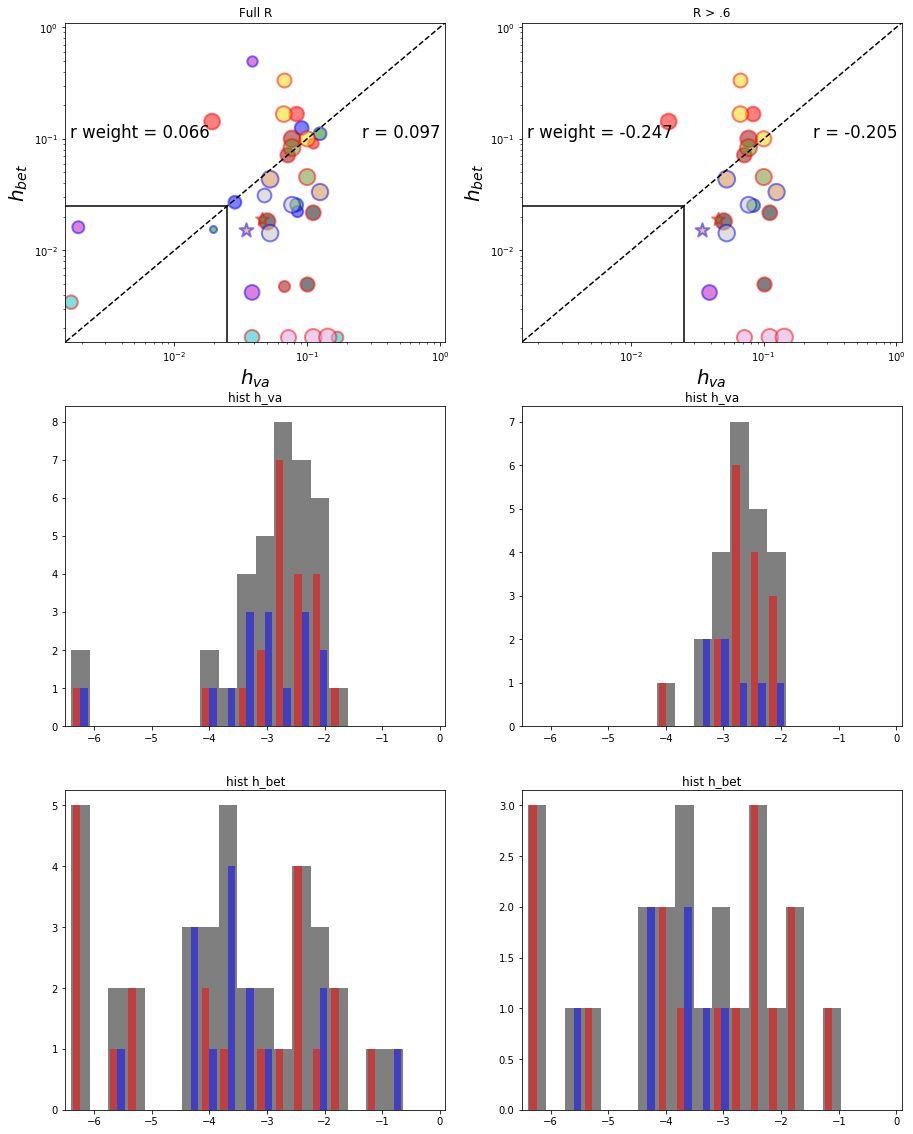

In [12]:
file = os.path.join('parametre', 'list_h_block.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
plot_fig(recording, nb_r='block')

OP CS IP YK RS AM DC FM TN BMC SR LB 

/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


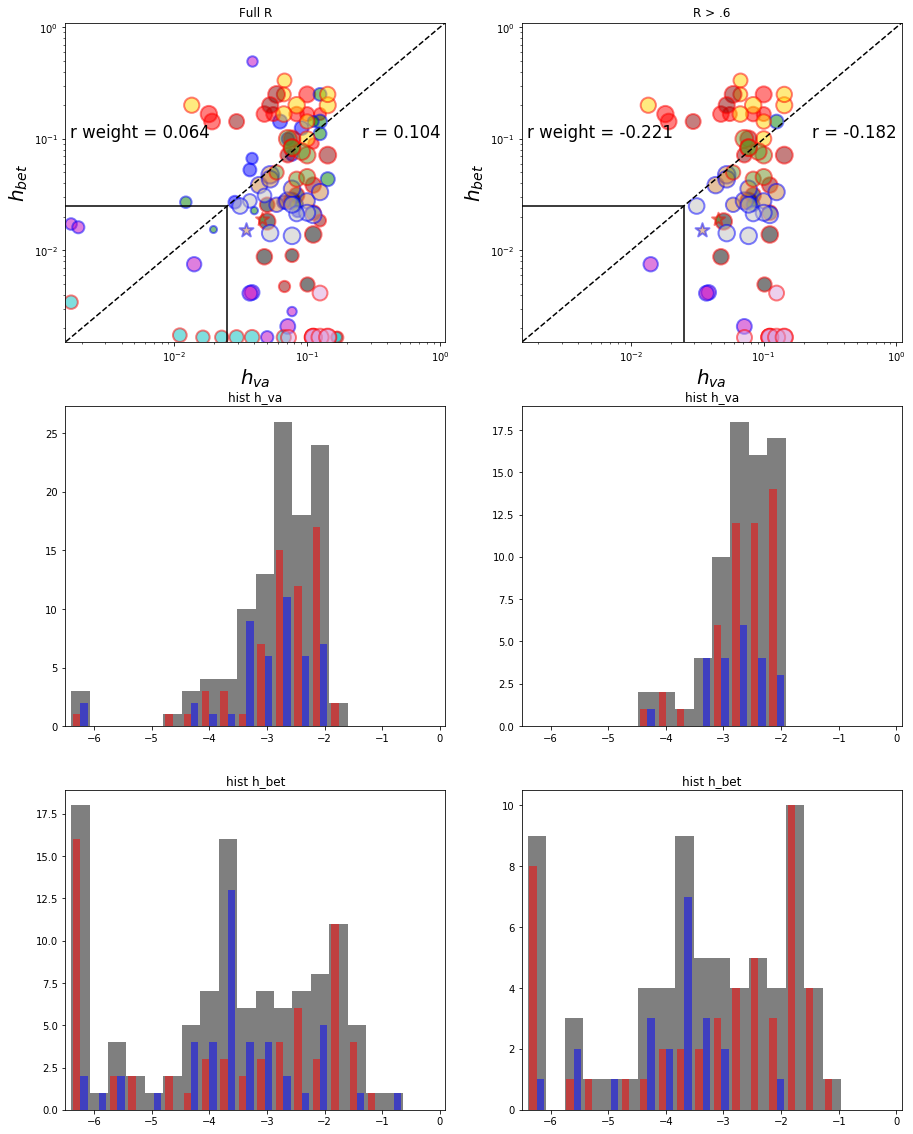

In [13]:
file = os.path.join('parametre', 'list_h_200.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
plot_fig(recording, nb_r=200)

OP CS IP YK RS AM DC FM TN BMC SR LB 

/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


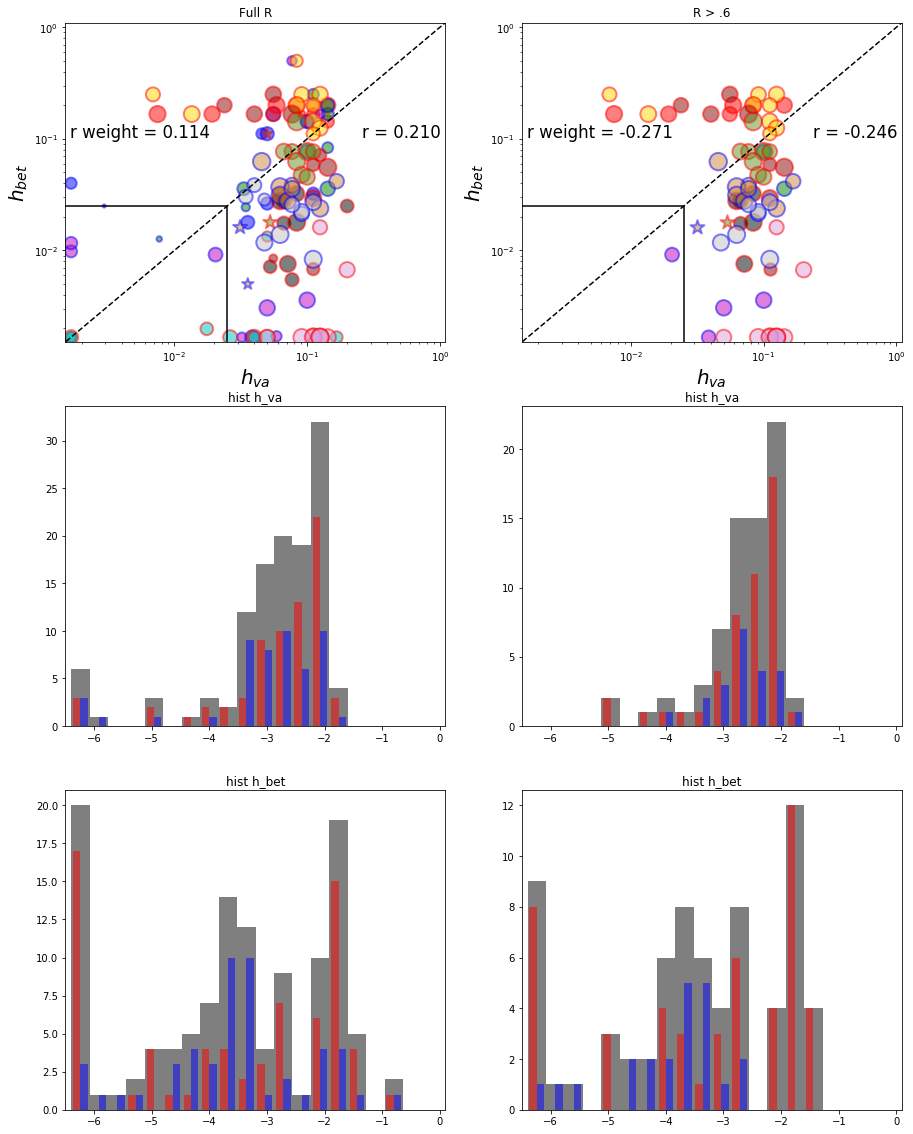

In [14]:
file = os.path.join('parametre', 'list_h_150.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
plot_fig(recording, nb_r=150)

OP CS IP YK RS AM DC FM TN BMC SR LB 

/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.5/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


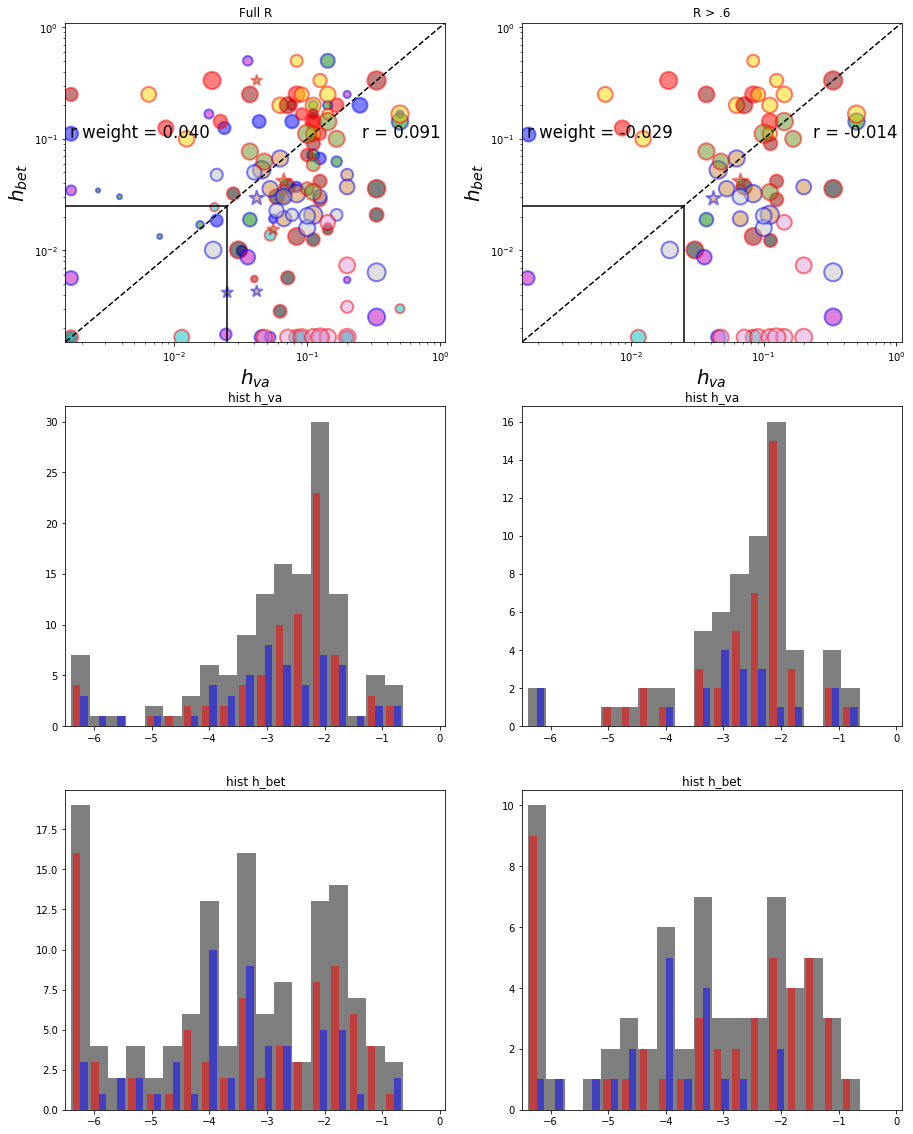

In [15]:
file = os.path.join('parametre', 'list_h_100.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')
plot_fig(recording, nb_r=100)